In [1]:
# !pip install earthengine-api

*Only need to authenticate once per Notebook*

In [2]:
# !earthengine authenticate

#### Following, in part: [GEE_downloadPRISM800_by_LandCover.py](https://gist.github.com/gponce-ars/b816c0801c3ce885207c826f45e1f30b)

In [3]:
import ee
ee.Initialize()
from geopandas import GeoDataFrame
from shapely.geometry import shape
import matplotlib.pyplot as plt
import ee.mapclient
import pandas as pd
import numpy as np
import csv

### 1. Import NLCD 2011

In [4]:
nlcd2011 = ee.Image('USGS/NLCD/NLCD2011')

### 2. Get points

In [5]:
df_coords = pd.read_csv('../R/exports/prison_ctrs_groups_latlon.csv', 
                        compression=None, header=0, sep=',', quotechar='"', low_memory=False, index_col=False)

df_coords.head()

,STATE,group,X,Y
0,AK,216,-151.529276,59.649347
1,AK,256,-135.333568,57.052658
2,AK,323,-132.377690,56.469473
3,AK,1399,-162.592879,66.896473
4,AK,2352,-152.373083,57.804570


### 3. Subset of points to work with for this example

In [6]:
df_coords_sub1 = df_coords[df_coords.STATE == "VT"]

df_coords_sub1

,STATE,group,X,Y
4096,VT,382,-72.990790,43.609690
4097,VT,383,-73.205638,44.446527
4098,VT,390,-72.027951,44.395525
4099,VT,392,-72.190936,44.906313
4100,VT,393,-73.132266,44.850090
4101,VT,2646,-73.080646,44.811123
4102,VT,2648,-72.445631,43.988301
4103,VT,4282,-72.438051,43.269814


### 4. Convert to list

In [7]:
valuesList = df_coords_sub1.to_numpy().tolist()
valuesList

[['VT', 382, -72.99078972571981, 43.609690292624855],
 ['VT', 383, -73.20563789558545, 44.446527100239074],
 ['VT', 390, -72.02795108949539, 44.395525260118774],
 ['VT', 392, -72.19093592889806, 44.90631302571161],
 ['VT', 393, -73.1322655013431, 44.85009049694831],
 ['VT', 2646, -73.08064623120555, 44.8111227879875],
 ['VT', 2648, -72.44563089625301, 43.988300959423924],
 ['VT', 4282, -72.43805111553525, 43.269813822491294]]

### 5. Convert to ee.List

In [8]:
valuesList = ee.List(valuesList)

print(type(valuesList))
valuesList.getInfo()

<class 'ee.ee_list.List'>


[['VT', 382, -72.99078972571981, 43.609690292624855],
 ['VT', 383, -73.20563789558545, 44.446527100239074],
 ['VT', 390, -72.02795108949539, 44.395525260118774],
 ['VT', 392, -72.19093592889806, 44.90631302571161],
 ['VT', 393, -73.1322655013431, 44.85009049694831],
 ['VT', 2646, -73.08064623120555, 44.8111227879875],
 ['VT', 2648, -72.44563089625301, 43.988300959423924],
 ['VT', 4282, -72.43805111553525, 43.269813822491294]]

### 6. Create feature collection

In [9]:
def list2fc(l):
    l1 = ee.List(l)
    geom = ee.Geometry.Point([l1.get(2), l1.get(3)])
    return ee.Feature(geom, {'state': l1.get(0), 'group': l1.get(1), 'longitude': l1.get(2), 'latitude': l1.get(3)})

In [10]:
myFeatures = ee.FeatureCollection(valuesList.map(list2fc))

type(myFeatures)

ee.featurecollection.FeatureCollection

### 7. Buffer feature collection

In [11]:
def bufferPoly(feature):
    return feature.buffer(10000)

In [12]:
MyBuffers = myFeatures.map(bufferPoly)

# take a peek
MyBuffers.getInfo().get('features')[1]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-73.20563789558545, 44.5365157597539],
    [-73.24089792938952, 44.53292879258012],
    [-73.27333910096395, 44.5224546780855],
    [-73.3003707461909, 44.50593055181301],
    [-73.31983922731773, 44.48467619578883],
    [-73.33019994920797, 44.46038758602194],
    [-73.33063869630404, 44.435000603150876],
    [-73.32113315053843, 44.410536158038056],
    [-73.30245073313499, 44.388939300373366],
    [-73.27608417042335, 44.37192512121584],
    [-73.24413094599345, 44.36084348527891],
    [-73.20912675840444, 44.35657296950412],
    [-73.17384610197799, 44.35945202087681],
    [-73.14108509182418, 44.36925247665411],
    [-73.11344268681262, 44.38519741317651],
    [-73.09311655563582, 44.40602199869571],
    [-73.08172898471113, 44.43007281131066],
    [-73.08019641598267, 44.45543813762091],
    [-73.08865339908598, 44.480099289158055],
    [-73.1064379655581, 44.50209116135967],
    [-73.1321408091208, 44.51965

### 8. Clip the image to the polygon geometry and extract the landcover band

In [13]:
nlcd2011c = nlcd2011.clip(MyBuffers)

landcover = nlcd2011c.select('landcover')
type(landcover)

ee.image.Image

*Can't make a map here in Python apparently, but check out [this workaround](https://stackoverflow.com/questions/46960328/workaround-for-google-earth-engine-python-api-and-no-support-for-ee-mapclient)*


### 9. Get the frequency of landcover occurrence for each buffer

Following this: https://stackoverflow.com/questions/47633088/get-results-in-an-earth-engine-python-script

In [14]:
frequency = landcover.reduceRegions(collection = MyBuffers, reducer = ee.Reducer.frequencyHistogram(), scale = 30)
type(frequency)

ee.featurecollection.FeatureCollection

### 10. Process to dataframe

* awkwardly at this point in my python experience
* some potential help: 
    * [stackexchange 1](https://gis.stackexchange.com/questions/278607/earth-engine-convert-list-with-coordinates-and-values-into-a-feature-collection)
    * [stackexchange 2](https://gis.stackexchange.com/questions/303138/google-earth-engine-remove-geometry-fields-from-featurecollection-for-export-t)
    * https://pypi.org/project/flatten-dict/
    * [stackoverflow 1](https://stackoverflow.com/questions/14692690/access-nested-dictionary-items-via-a-list-of-keys)
    * [stackoverflow 2](https://stackoverflow.com/questions/50283745/python-csv-writer-combine-two-columns-in-single-row)
    
    
##### a. remove geometry and process down a bit

In [15]:
def extract1(feat):
    feat = feat.setGeometry(None)
    return feat

data1 = frequency.map(extract1)

data1 = data1.getInfo()

wanted_keys = ['features'] 
data1 = dict((k, data1[k]) for k in wanted_keys if k in data1)
data1 = data1.get('features')

data1[1]

{'type': 'Feature',
 'geometry': None,
 'id': '1',
 'properties': {'group': 383,
  'histogram': {'11': 108111.09019607835,
   '21': 29022.231372549028,
   '22': 27142.61176470589,
   '23': 24710.262745098044,
   '24': 11158.592156862745,
   '31': 721.0,
   '41': 36318.149019607874,
   '42': 10282.188235294121,
   '43': 15253.023529411776,
   '52': 563.635294117647,
   '71': 332.4666666666667,
   '81': 55516.305882352885,
   '82': 5921.858823529412,
   '90': 15350.41960784314,
   '95': 5212.364705882353},
  'latitude': 44.446527100239074,
  'longitude': -73.20563789558545,
  'state': 'VT'}}

##### b. Process down some more

In [16]:
data2 = []
for d in data1:
    d = d.get('properties')
    data2.append(d)
data2[1]

{'group': 383,
 'histogram': {'11': 108111.09019607835,
  '21': 29022.231372549028,
  '22': 27142.61176470589,
  '23': 24710.262745098044,
  '24': 11158.592156862745,
  '31': 721.0,
  '41': 36318.149019607874,
  '42': 10282.188235294121,
  '43': 15253.023529411776,
  '52': 563.635294117647,
  '71': 332.4666666666667,
  '81': 55516.305882352885,
  '82': 5921.858823529412,
  '90': 15350.41960784314,
  '95': 5212.364705882353},
 'latitude': 44.446527100239074,
 'longitude': -73.20563789558545,
 'state': 'VT'}

##### c. get histogram and group data separately

In [17]:
histdata = []
for d in data2:
    d = d.get('histogram')
    histdata.append(d)
histdata[1]

{'11': 108111.09019607835,
 '21': 29022.231372549028,
 '22': 27142.61176470589,
 '23': 24710.262745098044,
 '24': 11158.592156862745,
 '31': 721.0,
 '41': 36318.149019607874,
 '42': 10282.188235294121,
 '43': 15253.023529411776,
 '52': 563.635294117647,
 '71': 332.4666666666667,
 '81': 55516.305882352885,
 '82': 5921.858823529412,
 '90': 15350.41960784314,
 '95': 5212.364705882353}

In [18]:
groupdata = []
for d in data2:
    del d['histogram']
    groupdata.append(d)

groupdata[1]

{'group': 383,
 'latitude': 44.446527100239074,
 'longitude': -73.20563789558545,
 'state': 'VT'}

##### d. convert to panda dataframe

In [19]:
group_df = pd.DataFrame(groupdata).merge(pd.DataFrame(histdata), left_on=None, right_on=None, 
                                          left_index=True, right_index=True)
group_df

,group,latitude,longitude,state,11,21,22,23,24,31,41,42,43,52,71,81,82,90,95
0,382,43.609690,-72.990790,VT,1001.090196,15896.325490,13382.090196,12412.137255,3090.788235,846.000000,138979.913725,48878.176471,41500.529412,2435.643137,4162.470588,31762.976471,7369.286275,20585.729412,3247.513725
1,383,44.446527,-73.205638,VT,108111.090196,29022.231373,27142.611765,24710.262745,11158.592157,721.000000,36318.149020,10282.188235,15253.023529,563.635294,332.466667,55516.305882,5921.858824,15350.419608,5212.364706
2,390,44.395525,-72.027951,VT,6022.807843,15224.003922,9703.552941,4981.439216,1271.898039,1024.000000,82425.976471,65612.949020,95828.074510,3084.466667,3661.690196,45439.870588,2163.247059,8122.196078,1047.023529
3,392,44.906313,-72.190936,VT,30424.654902,13363.200000,10572.458824,3613.862745,992.000000,1388.000000,45799.635294,52916.639216,68257.992157,2547.505882,3142.427451,69699.658824,10847.941176,28417.764706,3670.478431
4,393,44.850090,-73.132266,VT,101687.933333,12590.913725,13993.843137,6664.294118,2354.247059,907.000000,48087.349020,4347.239216,11083.662745,868.294118,315.000000,61795.074510,49247.552941,28868.129412,2839.905882
5,2646,44.811123,-73.080646,VT,30941.603922,13210.945098,13119.533333,5345.686275,1734.701961,160.843137,78969.368627,12226.376471,23652.815686,1119.560784,330.788235,86554.572549,42048.156863,30952.513725,5280.698039
6,2648,43.988301,-72.445631,VT,124.450980,14058.419608,2810.584314,832.666667,98.000000,105.929412,154407.854902,39968.101961,84369.537255,4477.501961,2323.294118,35623.121569,642.505882,5320.047059,416.066667
7,4282,43.269814,-72.438051,VT,7803.898039,14891.866667,10662.458824,5424.647059,929.109804,1024.619608,81023.278431,95995.207843,72887.635294,2941.341176,3265.372549,32279.435294,5745.235294,9349.388235,1298.490196


### 11. Visualize and export

##### a. Export raw data to csv

In [20]:
group_df.to_csv('../../data/processed/nlcd_data.csv', encoding='utf-8', index=False)

##### b. Calculate new df for proportions and plot some of it

select NLCD info (see [metadata](https://www.mrlc.gov/sites/default/files/metadata/landcover.html))

* 22	Developed, Low Intensity - Includes areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 20-49 percent of total cover. These areas most commonly include single-family housing units.	
* 23	Developed, Medium Intensity - Includes areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50-79 percent of the total cover. These areas most commonly include single-family housing units.	
* 24	Developed, High Intensity - Includes highly developed areas where people reside or work in high numbers. Examples include apartment complexes, row houses and commercial/industrial. Impervious surfaces account for 80 to 100 percent of the total cover.


In [21]:
df = pd.concat([group_df.iloc[:, 0], group_df.iloc[:, 4:]], axis=1)
df = df.set_index('group')
prp = df.div(df.sum(axis=1), axis=0)
prp.iloc[0:1, :]

,11,21,22,23,24,31,41,42,43,52,71,81,82,90,95
group,,,,,,,,,,,,,,,
382,0.002897,0.046003,0.038727,0.03592,0.008945,0.002448,0.402198,0.14145,0.1201,0.007049,0.012046,0.09192,0.021326,0.059574,0.009398


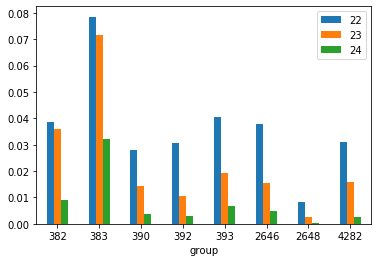

In [22]:
ax = prp.plot.bar(y = ['22', '23', '24'], rot = 0)
plt.show()